Make rarefaction curve: Count RS-only clusters cumulatively per Tara sample
-----

Does everything separately for `pelag` and `proch` data.

In [1]:
%matplotlib inline

### Function to plot mean +/- standard deviation for RS-assoc and all OGs on same plot (for paper) ...

In [134]:
# Main function
def rarefaction_paper(species, evalue, srf_only, clusters_path_all, clusters_path_rs, permutations, plot_redsea):

    """Make rarefaction curve for presence of gene clusters in Tara samples"""

    # Paths of input files, containing cluster counts
    paths = pd.Series.from_csv('~/singlecell/tara/paths_%s_%s.list' % (species, evalue), header=-1, sep='\t', index_col=None)
    if srf_only == True:
        paths = paths[paths.str.contains('SRF')]
    num_samples = paths.shape[0]
    
    # Data frame containing all samples cluster counts (NaN if missing)
    pieces = []
    for path in paths:
        fullpath = "~/singlecell/tara/PROK-139/%s" % path
        counts = pd.DataFrame.from_csv(fullpath, header=-1, sep='\t', index_col=0)
        pieces.append(counts)
    frame = pd.concat(pieces, axis=1)
    headings = paths.tolist()
    frame.columns = headings

    num_samples_plus_one = num_samples + 1

    fig = plt.figure(figsize=(10, 10))

    ### ALL OGS
    # Dataframe of clusters_all
    clusters = pd.Series.from_csv(clusters_path_all, header=-1, sep='\t', index_col=None)
    clusters_frame = frame.loc[clusters]
    num_genes = len(clusters)

    # Check if counts are greater than zero (presence/absence)
    bool_frame = clusters_frame > 0

    # For all OGs, plot rarefaction curve of avg +/- std of N random sample orders
    cum_list = []
    for i in range(0, permutations):
        # Randomize sample columns (rarefaction step)
        bool_frame_copy = randomize_df_column_order(bool_frame)
        # Replace column names with sequential numbers (prevents inconsistent plotting)
        bool_frame_copy.columns = range(0, len(bool_frame_copy.columns))
        # Go thru randomized columns and count cumulative times clusters found
        cumulative_frame = make_cumulative_frame(bool_frame_copy)
        # Check if cumulative count is greater than zero (presence/absence)
        cumulative_bool = cumulative_frame > 0
        # Sum cumulative count
        cumulative_sum = cumulative_bool.sum()
        # Add cumulutive sum to list
        cum_list.append(cumulative_sum)
    # Make new df
    cum_frame = pd.concat(cum_list, axis=1)
    # Calc avg and std of df
    cum_mean = cum_frame.mean(axis=1)
    cum_std = cum_frame.std(axis=1)
    # Plot
    plt.plot(range(1, num_samples_plus_one), cum_mean/num_genes, color=sns.xkcd_rgb['blue'], linestyle='--', label=None, zorder=10)
    plt.plot(range(1, num_samples_plus_one), (cum_mean + cum_std)/num_genes, color=sns.xkcd_rgb['blue'], label='All OGs')
    plt.plot(range(1, num_samples_plus_one), (cum_mean - cum_std)/num_genes, color=sns.xkcd_rgb['blue'], label=None)
    plt.fill_between(range(1, num_samples_plus_one), (cum_mean + cum_std)/num_genes, (cum_mean - cum_std)/num_genes, facecolor=sns.xkcd_rgb['blue'], alpha=0.5)

    # Print statistics
    found_genes = float(cumulative_sum.max())
    diff_genes = float(num_genes - found_genes)
    print('\nALL OGS')
    print('Clusters found:\t%s\t(%f)' % (int(found_genes), found_genes/num_genes))
    print('Not found:\t%s\t(%f)' % (int(diff_genes), diff_genes/num_genes))
    

    ### RS-ASSOC OGS
    # Dataframe of clusters_rs
    clusters = pd.Series.from_csv(clusters_path_rs, header=-1, sep='\t', index_col=None)
    clusters_frame = frame.loc[clusters]
    num_genes = len(clusters)

    # Check if counts are greater than zero (presence/absence)
    bool_frame = clusters_frame > 0

    # For RS-assoc OGs, plot rarefaction curve of avg +/- std of N random sample orders
    cum_list = []
    for i in range(0, permutations):
        # Randomize sample columns (rarefaction step)
        bool_frame_copy = randomize_df_column_order(bool_frame)
        # Replace column names with sequential numbers (prevents inconsistent plotting)
        bool_frame_copy.columns = range(0, len(bool_frame_copy.columns))
        # Go thru randomized columns and count cumulative times clusters found
        cumulative_frame = make_cumulative_frame(bool_frame_copy)
        # Check if cumulative count is greater than zero (presence/absence)
        cumulative_bool = cumulative_frame > 0
        # Sum cumulative count
        cumulative_sum = cumulative_bool.sum()
        # Add cumulutive sum to list
        cum_list.append(cumulative_sum)
    # Make new df
    cum_frame = pd.concat(cum_list, axis=1)
    # Calc avg and std of df
    cum_mean = cum_frame.mean(axis=1)
    cum_std = cum_frame.std(axis=1)
    # Plot
    plt.plot(range(1, num_samples_plus_one), cum_mean/num_genes, color=sns.xkcd_rgb['orange'], linestyle='--', label=None)
    plt.plot(range(1, num_samples_plus_one), (cum_mean + cum_std)/num_genes, color=sns.xkcd_rgb['orange'], label='Red Sea-associated OGs')
    plt.plot(range(1, num_samples_plus_one), (cum_mean - cum_std)/num_genes, color=sns.xkcd_rgb['orange'], label=None)
    plt.fill_between(range(1, num_samples_plus_one), (cum_mean + cum_std)/num_genes, (cum_mean - cum_std)/num_genes, facecolor=sns.xkcd_rgb['orange'], alpha=0.5)

    # Print statistics
    found_genes = float(cumulative_sum.max())
    diff_genes = float(num_genes - found_genes)
    print('RS-ASSOC OGS')
    print('Clusters found:\t%s\t(%f)' % (int(found_genes), found_genes/num_genes))
    print('Not found:\t%s\t(%f)' % (int(diff_genes), diff_genes/num_genes))
    

    ### OPTION: RED SEA CURVE
    # Plot rarefaction curve for RS samples
    if plot_redsea:
        redsea = ['031_SRF_0.22-1.6', '032_SRF_0.22-1.6', '032_DCM_0.22-1.6', '033_SRF_0.22-1.6', '034_SRF_0.22-1.6', '034_DCM_0.22-1.6']
        redsea = [species + '_' + s + '_' + evalue for s in redsea]
        cum_list = []
        for i in range(0, permutations):
            last_six_columns = []
            last_six_columns.append([str(w) for w in random.sample(redsea, len(redsea))])
            #last_six_columns = random.shuffle(redsea) <== doesn't work
            bool_frame_copy = randomize_df_column_order(bool_frame)
            old_columns = bool_frame_copy.columns
            nonrs_columns = old_columns.drop(last_six_columns[0])
            new_columns = nonrs_columns.tolist() + last_six_columns[0]
            new_frame = pd.DataFrame(data=bool_frame_copy, columns=new_columns)
            # Replace column names with sequential numbers (prevents inconsistent plotting)
            new_frame.columns = range(0, len(new_frame.columns))
            # Go thru randomized columns and count cumulative times clusters found
            cumulative_frame = make_cumulative_frame(new_frame)
            # Check if cumulative count is greater than zero (presence/absence)
            cumulative_bool = cumulative_frame > 0
            # Sum cumulative count
            cumulative_sum = cumulative_bool.sum()
            # Add cumulutive sum to list
            cum_list.append(cumulative_sum)
        # If we want to know how many clusters are added by last six samples...
        # print cum_list
        # Make new df
        cum_frame = pd.concat(cum_list, axis=1)
        # Calc avg and std of df
        cum_mean = cum_frame.mean(axis=1)
        cum_std = cum_frame.std(axis=1)
        # Plot
        plt.plot(range(1, num_samples_plus_one), cum_mean/num_genes, color='red', linestyle='-', label='Mean, 6 Red Sea samples last')
        #plt.plot(range(1, num_samples_plus_one), cum_mean + cum_std, color='red', label='     plus standard deviation')
        #plt.plot(range(1, num_samples_plus_one), cum_mean - cum_std, color='red', label='     minus standard deviation')
        #plt.fill_between(range(1, num_samples_plus_one), cum_mean + cum_std, cum_mean - cum_std, facecolor='red', alpha=0.5)
        plt.annotate('Red Sea samples added', xy=(num_samples-6, cum_mean[num_samples-6]/num_genes), xytext=(num_samples-20, cum_mean[num_samples-1]*1.05), horizontalalignment='right', arrowprops=dict(arrowstyle="->", connectionstyle="angle,angleA=0,angleB=90,rad=10"))
    
    ### LEGEND
    # Add the legend with some customizations
    plt.legend(loc='lower right', fontsize=16)

    if srf_only == True:
        group = 'surface'
    else:
        group = 'SRF_MIX_DCM_MES'
    
    ### FORMAT AXIS
    # Format and save plot
    plt.xlabel('Number of Tara %s samples added' % group, fontsize=18)
    plt.ylabel('Cumulative proportion of OGs observed', fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    #plt.grid(TRUE)
    ymax = 1
    plt.axis([0, num_samples*1.1, 0, ymax])
    
    plt.savefig('/Users/luke/singlecell/notebooks/rarefaction_tara_%s_%s.pdf' % (group, species))


### ... run code


ALL OGS
Clusters found:	4342	(0.823596)
Not found:	930	(0.176404)
RS-ASSOC OGS
Clusters found:	682	(0.776765)
Not found:	196	(0.223235)


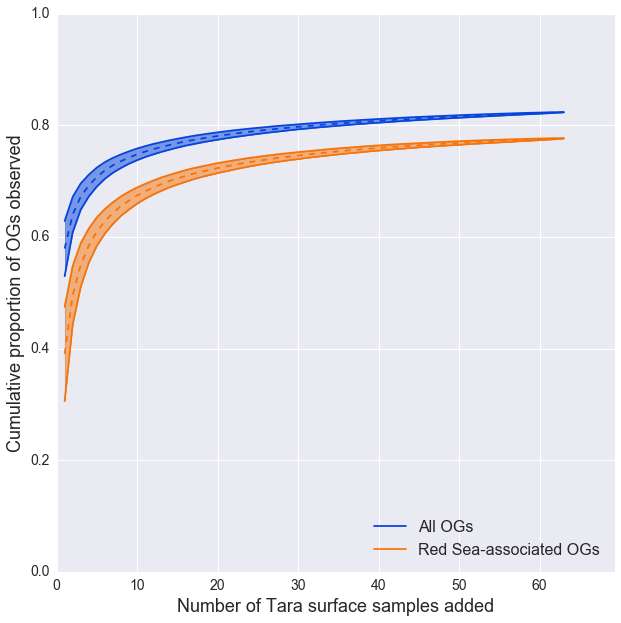

In [139]:
species = 'pelag'
evalue = '1e-5'
srf_only = True # if True, num_samples = 63; if False, num_samples = 139
clusters_path_all = '/Users/luke/singlecell/clusters/orthomcl-sar4/groups.all_sar.list'
clusters_path_rs = '/Users/luke/singlecell/clusters/orthomcl-sar4/groups.RSonly_sar.list'
permutations = 1000
plot_redsea = False

rarefaction_paper(species, evalue, srf_only, clusters_path_all, clusters_path_rs, permutations, plot_redsea)


ALL OGS
Clusters found:	4475	(0.848824)
Not found:	797	(0.151176)
RS-ASSOC OGS
Clusters found:	713	(0.812073)
Not found:	165	(0.187927)


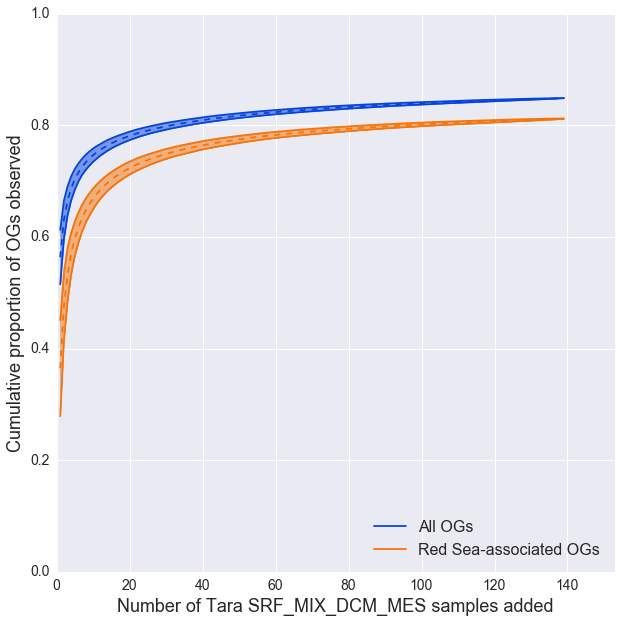

In [140]:
species = 'pelag'
evalue = '1e-5'
srf_only = False # if True, num_samples = 63; if False, num_samples = 139
clusters_path_all = '/Users/luke/singlecell/clusters/orthomcl-sar4/groups.all_sar.list'
clusters_path_rs = '/Users/luke/singlecell/clusters/orthomcl-sar4/groups.RSonly_sar.list'
permutations = 1000
plot_redsea = False

rarefaction_paper(species, evalue, srf_only, clusters_path_all, clusters_path_rs, permutations, plot_redsea)


ALL OGS
Clusters found:	6945	(0.665294)
Not found:	3494	(0.334706)
RS-ASSOC OGS
Clusters found:	63	(0.656250)
Not found:	33	(0.343750)


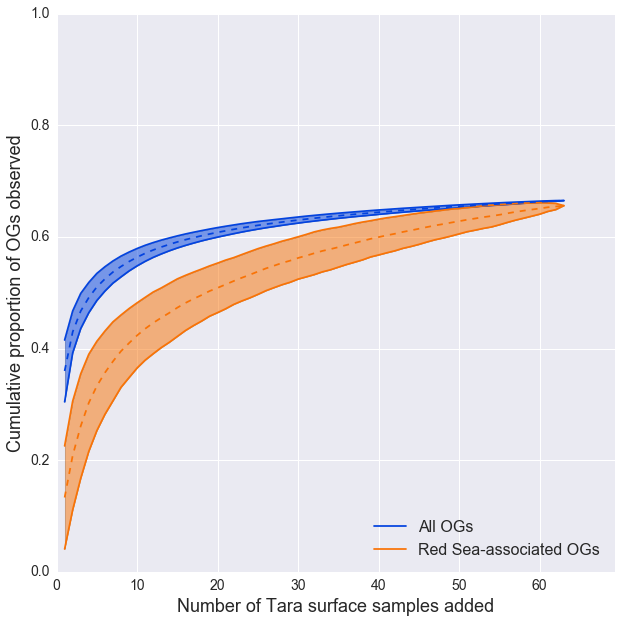

In [141]:
species = 'proch'
evalue = '1e-5'
srf_only = True # if True, num_samples = 63; if False, num_samples = 139
clusters_path_all = '/Users/luke/singlecell/clusters/orthomcl-pro4/groups.all_pro.list'
clusters_path_rs = '/Users/luke/singlecell/clusters/orthomcl-pro4/groups.RSonly_pro.list'
permutations = 1000
plot_redsea = False

rarefaction_paper(species, evalue, srf_only, clusters_path_all, clusters_path_rs, permutations, plot_redsea)


ALL OGS
Clusters found:	7537	(0.722004)
Not found:	2902	(0.277996)
RS-ASSOC OGS
Clusters found:	67	(0.697917)
Not found:	29	(0.302083)


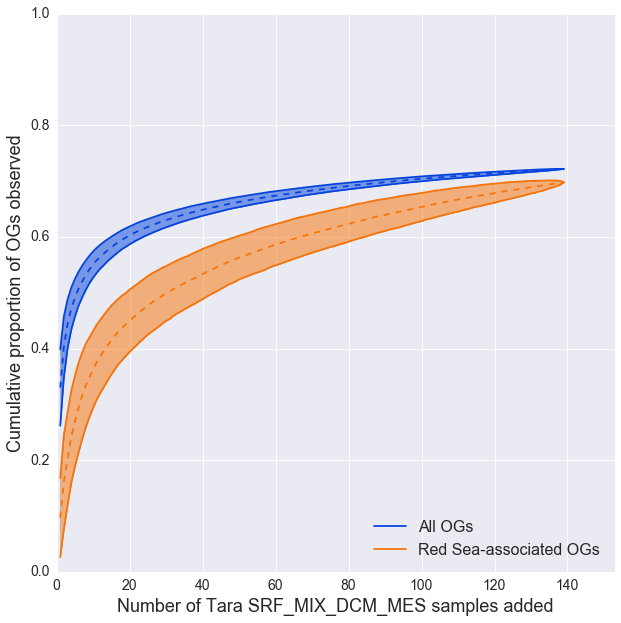

In [142]:
species = 'proch'
evalue = '1e-5'
srf_only = False # if True, num_samples = 63; if False, num_samples = 139
clusters_path_all = '/Users/luke/singlecell/clusters/orthomcl-pro4/groups.all_pro.list'
clusters_path_rs = '/Users/luke/singlecell/clusters/orthomcl-pro4/groups.RSonly_pro.list'
permutations = 1000
plot_redsea = False

rarefaction_paper(species, evalue, srf_only, clusters_path_all, clusters_path_rs, permutations, plot_redsea)

### ... count the number of each Tara sample depth

In [83]:
paths = pd.Series.from_csv('~/singlecell/tara/paths_pelag_1e-5.list', header=-1, sep='\t', index_col=None)

In [84]:
print 'SRF\tDCM\tMES\tMIX'
print paths[paths.str.contains('SRF')].shape, '\t', paths[paths.str.contains('DCM')].shape, '\t', paths[paths.str.contains('MES')].shape, '\t', paths[paths.str.contains('MIX')].shape

SRF	DCM	MES	MIX
(63,) 	(42,) 	(30,) 	(4,)


### Old code showing best-case and worst-case scenario

In [4]:
#!/usr/bin/env python

import click
import numpy as np
import pandas as pd
import random
import math
import re
import matplotlib.pyplot as plt 
import seaborn as sns

# Function: Randomize columns order of pandas DataFrame
def randomize_df_column_order(df):
    cols = df.columns.tolist()
    np.random.shuffle(cols)
    df_copy = df[cols]
    return df_copy

# Function: Count cumulative true values in each row by column
def make_cumulative_frame(df):
    prev_count = pd.Series(data=0, index=df.index)
    cumulative_frame = pd.DataFrame(data=0, index=df.index, columns=df.columns)
    for sample in df.columns:
        cumulative_frame[sample] = prev_count + df[sample]
        prev_count = cumulative_frame[sample]
    return cumulative_frame

# Function: Find best (greatest) cumulative sum
def find_best_cumulative_frame(df):
    # initialize values
    prev_count = pd.Series(data=0, index=df.index)
    col_list = []
    dfb = pd.DataFrame(data=df.values, index=df.index, columns=df.columns)
    # go through selection for as many samples exist
    for sample in dfb.columns:
        # add prev_count to dfb
        dfc = dfb.add(prev_count.tolist(), axis=0)
        # find column with most values > 0
        dfd = dfc > 0
        num_gt_zero = dfd.sum()
        best = num_gt_zero.idxmax()
        best_value = num_gt_zero.max()
        # set best column as new prev_count and make it last column in new df
        prev_count = dfc[best]
        col_list.append(prev_count)
        # remove column from dfb
        dfb.pop(best)
    # make new df
    cumulative_frame = pd.concat(col_list, axis=1)
    return cumulative_frame

# Function: Find worst (least) cumulative sum
def find_worst_cumulative_frame(df):
    # initialize values
    prev_count = pd.Series(data=0, index=df.index)
    col_list = []
    dfb = pd.DataFrame(data=df.values, index=df.index, columns=df.columns)
    # go through selection for as many samples exist
    for sample in dfb.columns:
        # add prev_count to dfb
        dfc = dfb.add(prev_count.tolist(), axis=0)
        # find column with most values > 0
        dfd = dfc > 0
        num_gt_zero = dfd.sum()
        worst = num_gt_zero.idxmin()
        worst_value = num_gt_zero.min()
        # set best column as new prev_count and make it last column in new df
        prev_count = dfc[worst]
        col_list.append(prev_count)
        # remove column from dfb
        dfb.pop(worst)
    # make new df
    cumulative_frame = pd.concat(col_list, axis=1)
    return cumulative_frame

# @click.command()
# @click.option('--num_samples', required=True, type=click.INT, help='Number of samples, e.g. 139 for all prokaryotic samples')
# @click.option('--species', required=True, type=click.STRING, help='species (pelag or proch) corresponding to cluster counts input files, e.g. pelag_004_SRF_0.22-1.6_1e-5')
# @click.option('--evalue', required=True, type=click.STRING, help='e-value cutoff corresponding to cluster counts input files, e.g. pelag_004_SRF_0.22-1.6_1e-5')
# @click.option('--clusters_set', required=True, type=click.STRING, help='Clusters set that is given by --clusters_path, e.g. RSonly or all')
# @click.option('--clusters_path', required=True, type=click.Path(resolve_path=True, readable=True, exists=True), help='Clusters file to check for presence, e.g. ~/singlecell/clusters/orthomcl-sar4/groups.RSonly_sar.list')
# @click.option('--permutations', required=True, type=int, help='Number of rarefaction curve permutations to draw')
# @click.option('--plot_redsea', is_flag=True, help='Provide this flag if you want to superimpose rarafaction curve where Red Sea Tara samples are explored first')

# num_samples = 139
# species = 'proch'
# evalue = '1e-5'
# clusters_set = 'all'
# clusters_path = '~/singlecell/clusters/orthomcl-pro4/groups.all_pro.list'
# permutations = 100
# plot_redsea = False

# Main function
def rarefaction(num_samples, species, evalue, clusters_set, clusters_path, permutations, plot_redsea):

    """Make rarefaction curve for presence of gene clusters in Tara samples"""

    # Paths of input files, containing cluster counts
    paths = pd.Series.from_csv('~/singlecell/tara/paths_%s_%s.list' % (species, evalue), header=-1, sep='\t', index_col=None)

    # Data frame containing all samples cluster counts (NaN if missing)
    pieces = []
    for path in paths:
        fullpath = "~/singlecell/tara/PROK-139/%s" % path
        counts = pd.DataFrame.from_csv(fullpath, header=-1, sep='\t', index_col=0)
        pieces.append(counts)
    frame = pd.concat(pieces, axis=1)
    headings = paths.tolist()
    frame.columns = headings

    # Dataframe of clusters
    clusters = pd.Series.from_csv(clusters_path, header=-1, sep='\t', index_col=None)
    clusters_frame = frame.loc[clusters]

    # Check if counts are greater than zero (presence/absence)
    bool_frame = clusters_frame > 0

    # Plot best and worst curves
    cum_frame_best = find_best_cumulative_frame(bool_frame)
    cum_bool_best = cum_frame_best > 0
    cum_sum_best = cum_bool_best.sum()
    num_samples_plus_one = num_samples + 1
    # plt.plot(range(1, num_samples_plus_one), cum_sum_best, color='b', label='Best-case scenario')
    cum_frame_worst = find_worst_cumulative_frame(bool_frame)
    cum_bool_worst = cum_frame_worst > 0
    cum_sum_worst = cum_bool_worst.sum()
    # plt.plot(range(1, num_samples_plus_one), cum_sum_worst, color='b', label='Worst-case scenario')
    plt.fill_between(range(1, num_samples_plus_one), cum_sum_best, cum_sum_worst, facecolor='blue', alpha=0.3, label=None)

    # Save list of clusters not found
    final_result = cum_bool_best.iloc[0:,-1:]
    genes_not_found = final_result.loc[final_result.all(axis=1) == False].index.values
    np.savetxt('missing_%s_%s_%s.txt' % (species, clusters_set, evalue), genes_not_found, fmt="%s", delimiter=',')

    # Plot rarefaction curve of avg +/- std of N random sample orders
    cum_list = []
    for i in range(0, permutations):
        # Randomize sample columns (rarefaction step)
        bool_frame_copy = randomize_df_column_order(bool_frame)
        # Replace column names with sequential numbers (prevents inconsistent plotting)
        bool_frame_copy.columns = range(0, len(bool_frame_copy.columns))
        # Go thru randomized columns and count cumulative times clusters found
        cumulative_frame = make_cumulative_frame(bool_frame_copy)
        # Check if cumulative count is greater than zero (presence/absence)
        cumulative_bool = cumulative_frame > 0
        # Sum cumulative count
        cumulative_sum = cumulative_bool.sum()
        # Add cumulutive sum to list
        cum_list.append(cumulative_sum)
    # Make new df
    cum_frame = pd.concat(cum_list, axis=1)
    # Calc avg and std of df
    cum_mean = cum_frame.mean(axis=1)
    cum_std = cum_frame.std(axis=1)
    # Plot
    plt.plot(range(1, num_samples_plus_one), cum_mean, color='yellow', linestyle='--', label='Mean of cumulative gene counts +/- std')
    plt.plot(range(1, num_samples_plus_one), cum_mean + cum_std, color='yellow', label=None)
    plt.plot(range(1, num_samples_plus_one), cum_mean - cum_std, color='yellow', label=None)
    plt.fill_between(range(1, num_samples_plus_one), cum_mean + cum_std, cum_mean - cum_std, facecolor='yellow', alpha=0.5)

    # Plot rarefaction curve for RS samples
    if plot_redsea:
        redsea = ['031_SRF_0.22-1.6', '032_SRF_0.22-1.6', '032_DCM_0.22-1.6', '033_SRF_0.22-1.6', '034_SRF_0.22-1.6', '034_DCM_0.22-1.6']
        redsea = [species + '_' + s + '_' + evalue for s in redsea]
        cum_list = []
        for i in range(0, permutations):
            last_six_columns = []
            last_six_columns.append([str(w) for w in random.sample(redsea, len(redsea))])
            #last_six_columns = random.shuffle(redsea) <== doesn't work
            bool_frame_copy = randomize_df_column_order(bool_frame)
            old_columns = bool_frame_copy.columns
            nonrs_columns = old_columns.drop(last_six_columns[0])
            new_columns = nonrs_columns.tolist() + last_six_columns[0]
            new_frame = pd.DataFrame(data=bool_frame_copy, columns=new_columns)
            # Replace column names with sequential numbers (prevents inconsistent plotting)
            new_frame.columns = range(0, len(new_frame.columns))
            # Go thru randomized columns and count cumulative times clusters found
            cumulative_frame = make_cumulative_frame(new_frame)
            # Check if cumulative count is greater than zero (presence/absence)
            cumulative_bool = cumulative_frame > 0
            # Sum cumulative count
            cumulative_sum = cumulative_bool.sum()
            # Add cumulutive sum to list
            cum_list.append(cumulative_sum)
        # If we want to know how many clusters are added by last six samples...
        # print cum_list
        # Make new df
        cum_frame = pd.concat(cum_list, axis=1)
        # Calc avg and std of df
        cum_mean = cum_frame.mean(axis=1)
        cum_std = cum_frame.std(axis=1)
        # Plot
        plt.plot(range(1, num_samples_plus_one), cum_mean, color='red', linestyle='-', label='Mean, 6 Red Sea samples last')
        #plt.plot(range(1, num_samples_plus_one), cum_mean + cum_std, color='red', label='     plus standard deviation')
        #plt.plot(range(1, num_samples_plus_one), cum_mean - cum_std, color='red', label='     minus standard deviation')
        #plt.fill_between(range(1, num_samples_plus_one), cum_mean + cum_std, cum_mean - cum_std, facecolor='red', alpha=0.5)
        plt.annotate('Red Sea samples added', xy=(num_samples-6, cum_mean[num_samples-6]), xytext=(num_samples-20, cum_mean[num_samples-1]*1.05), horizontalalignment='right', arrowprops=dict(arrowstyle="->", connectionstyle="angle,angleA=0,angleB=90,rad=10"))

    # Save best and worst cumulative sum lists to csv
    cum_sum_best.to_csv('cum_sum_best_%s_%s_%s.csv' % (species, clusters_set, evalue))    
    cum_sum_worst.to_csv('cum_sum_worst_%s_%s_%s.csv' % (species, clusters_set, evalue))    

    # Add symbols for sample depth to best and worst curves
    cum_sum_best_index = [re.sub(r'(proch|pelag)_[0-9]{3}[ab]?_(SRF|DCM|MES|MIX)_.*', r'\2', i) for i in cum_sum_best.index]
    cum_sum_best.index = cum_sum_best_index
    best = pd.DataFrame(cum_sum_best)
    best['depth'] = best.index
    best.index = range(1, len(cum_sum_best)+1)
    best['sample_order'] = best.index
    best['cum_sum'] = best[0]
    del best[0]
    srf_best = best[best['depth'] == 'SRF']
    mix_best = best[best['depth'] == 'MIX']
    dcm_best = best[best['depth'] == 'DCM']
    mes_best = best[best['depth'] == 'MES']
    plt.plot(srf_best.sample_order, srf_best.cum_sum, 'bo', markeredgecolor='red', linewidth=4, markersize=3, markerfacecolor='red', label='Surface samples')
    plt.plot(mix_best.sample_order, mix_best.cum_sum, 'bo', markeredgecolor='orange', linewidth=4, markersize=3, markerfacecolor='orange', label='Mixed layer samples')
    plt.plot(dcm_best.sample_order, dcm_best.cum_sum, 'bo', markeredgecolor='green', linewidth=4, markersize=3, markerfacecolor='green', label='DCM samples')
    plt.plot(mes_best.sample_order, mes_best.cum_sum, 'bo', markeredgecolor='blue', linewidth=4, markersize=3, markerfacecolor='blue', label='Mesopelagic samples')
    
    cum_sum_worst_index = [re.sub(r'(proch|pelag)_[0-9]{3}[ab]?_(SRF|DCM|MES|MIX)_.*', r'\2', i) for i in cum_sum_worst.index]
    cum_sum_worst.index = cum_sum_worst_index
    worst = pd.DataFrame(cum_sum_worst)
    worst['depth'] = worst.index
    worst.index = range(1, len(cum_sum_worst)+1)
    worst['sample_order'] = worst.index
    worst['cum_sum'] = worst[0]
    del worst[0]
    srf_worst = worst[worst['depth'] == 'SRF']
    mix_worst = worst[worst['depth'] == 'MIX']
    dcm_worst = worst[worst['depth'] == 'DCM']
    mes_worst = worst[worst['depth'] == 'MES']
    plt.plot(srf_worst.sample_order, srf_worst.cum_sum, 'bo', markeredgecolor='red', linewidth=4, markersize=3, markerfacecolor='red', label=None)
    plt.plot(mix_worst.sample_order, mix_worst.cum_sum, 'bo', markeredgecolor='orange', linewidth=4, markersize=3, markerfacecolor='orange', label=None)
    plt.plot(dcm_worst.sample_order, dcm_worst.cum_sum, 'bo', markeredgecolor='green', linewidth=4, markersize=3, markerfacecolor='green', label=None)
    plt.plot(mes_worst.sample_order, mes_worst.cum_sum, 'bo', markeredgecolor='blue', linewidth=4, markersize=3, markerfacecolor='blue', label=None)

    # Plot number of clusters as horizontal line
    num_genes = len(clusters)
    plt.axhline(y=num_genes, color='k', linestyle='--', label='Total clusters (%s)' % num_genes)
    #plt.text(22, num_genes*0.95, 'Number %s clusters (%s)' % (clusters_set, num_genes))
    found_genes = cumulative_sum.max()
    #plt.text(22, found_genes*1.05, 'Found %s clusters (%s)' % (clusters_set, found_genes))
    plt.annotate('', xy=(num_samples, found_genes), xytext=(num_samples, num_genes), arrowprops={'arrowstyle': '<->'})
    diff_genes = num_genes - found_genes
    plt.text(5, (num_genes+found_genes)/2, 'Clusters found: %s' % (found_genes))
    plt.text(num_samples-3, (num_genes+found_genes)/2, 'Not found: %s' % (diff_genes), horizontalalignment='right')

    # Add the legend with some customizations
    legend = plt.legend(loc='lower right', shadow=True)
    # The frame is matplotlib.patches.Rectangle instance surrounding the legend.
    frame = legend.get_frame()
    frame.set_facecolor('0.90')
    # Set label fontsize
    for label in legend.get_texts():
        label.set_fontsize('small')
    for label in legend.get_lines():
        label.set_linewidth(1.5)  # the legend line width

    # Format and save plot
    plt.xlabel('Number of Tara samples added')
    plt.ylabel('Number of %s clusters found (e-value: %s)' % (clusters_set, evalue))
    plt.title('Rarefaction curve: %s (e-value: %s)' % (species, evalue))
    #plt.grid(TRUE)
    ymax = num_genes - (num_genes % 100) + 100
    plt.axis([0, num_samples+10, 0, ymax])
    # if species == 'proch':
    #     plt.axis([0, num_samples+10, -20, ymax])
    #     plt.axhline(y=0, color='k')
    plt.savefig('cum_%s_%s_%s.pdf' % (species, clusters_set, evalue))

# if __name__ == '__main__':
#     rarefaction()


/Users/luke/anaconda/envs/qiime190/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
